# Embedding 

In [4]:
%matplotlib inline

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import TSNE
import umap

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

import tqdm
from tqdm import tqdm

## Optimization
- Optimize for embedding dimensions 2 and visualize 1, 2, 3 dimensions using hyperparameter combinations

In [6]:
embedding_dim = 2

## Processed Data
- Let's optimize for each method independnetly

In [7]:
# DAT_TYPE = "processed"
DAT_TYPE = "raw"

In [8]:
if DAT_TYPE == "processed":
    X = np.load("data/processed_data.npy")
else:
    X = np.load("data/preliminary_X.npy")
    
y = np.load("data/preliminary_y.npy") # same order

In [9]:
y = y.astype(bool)

In [10]:
X.shape

(967, 220498)

## Normalization

In [ ]:
import soundfile as sf
import pyloudnorm as pyln

data, rate = sf.read("test.wav") # load audio

# peak normalize audio to -1 dB
peak_normalized_audio = pyln.normalize.peak(data, -1.0)

# measure the loudness first 
meter = pyln.Meter(rate) # create BS.1770 meter
loudness = meter.integrated_loudness(data)

# loudness normalize audio to -12 dB LUFS
loudness_normalized_audio = pyln.normalize.loudness(data, loudness, -12.0)

### PCA

In [8]:
# PCA
pca = PCA(n_components=embedding_dim)
model_pca = pca.fit(X)
embed_pca = model_pca.transform(X)
fit_variances = model_pca.explained_variance_ratio_

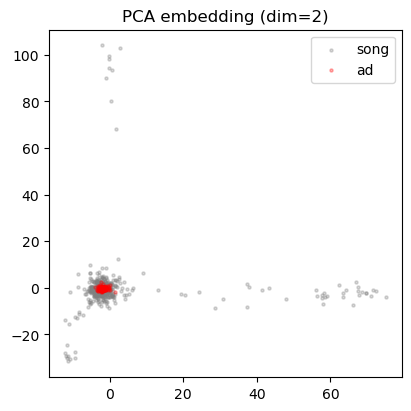

In [9]:
plt.close("all")

fig, ax = plt.subplots(figsize=(4, 4), layout="constrained")

ax.scatter(embed_pca[~y, 0], embed_pca[~y, 1],
              c="gray", label="song", alpha=0.3, s=5)
ax.scatter(embed_pca[y, 0], embed_pca[y, 1],
              c="red", label="ad", alpha=0.3, s=5)
ax.set_title(f"PCA embedding (dim={embedding_dim})")

plt.legend(loc="best")

plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-PCA.png", dpi=300)

plt.show()

### Spectral Embedding

In [10]:
gamma_range = np.logspace(-2, 1, 4) 
param_grid_rbf = {
    'n_components': [2],
    'affinity': ['rbf'],
    'gamma': gamma_range,
}

neighbors_range = np.logspace(2, 8, 4, base=2, dtype=int)  
param_grid_nn = {
    'n_components': [2],
    'affinity': ['nearest_neighbors'],
    'n_neighbors': neighbors_range,
}

grid_rbf = list(ParameterGrid(param_grid_rbf))
grid_nn = list(ParameterGrid(param_grid_nn))

In [11]:
spectral_embeddings = []
for params in grid_rbf:
    spectral = SpectralEmbedding(**params)
    embed_spectral = spectral.fit_transform(X)
    spectral_embeddings.append(embed_spectral)

for params in grid_nn:
    spectral = SpectralEmbedding(**params)
    embed_spectral = spectral.fit_transform(X)
    spectral_embeddings.append(embed_spectral)

/Users/sionkim/anaconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/sionkim/anaconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/sionkim/anaconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/sionkim/anaconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [12]:
params_combined = grid_rbf + grid_nn

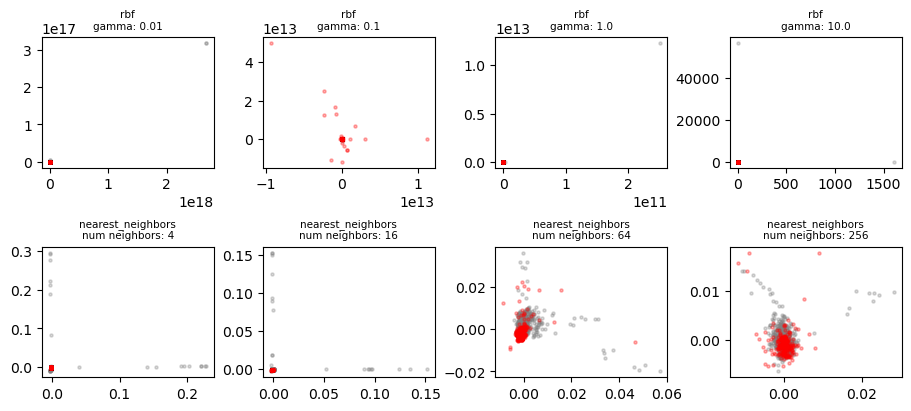

In [13]:
plt.close("all")

fig, axes = plt.subplots(2, 4, figsize=(9, 4), layout="constrained")

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.scatter(spectral_embeddings[i][~y, 0], spectral_embeddings[i][~y, 1], 
               c="gray", label="song", alpha=0.3, s=5)
    ax.scatter(spectral_embeddings[i][y, 0], spectral_embeddings[i][y, 1], 
               c="red", label="ad", alpha=0.3, s=5)

    if params_combined[i]["affinity"] == "rbf":
        ax.set_title(f'{params_combined[i]["affinity"]}\ngamma: {params_combined[i]["gamma"]}', fontsize=7.5)
    else:
        ax.set_title(f'{params_combined[i]["affinity"]}\nnum neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)


# plt.legend(loc="upper right")

plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-spectral.png", dpi=300)

plt.show()

### t-SNE

In [14]:
# perplexity_range = np.logspace(2, 9, 8, base=2, dtype=int)
perplexity_range = [2, 32, 64, 128, 256, 512, 768, 896]
perplexity_range

[2, 32, 64, 128, 256, 512, 768, 896]

In [15]:
param_grid_tsne = {
    'n_components': [2],
    'perplexity': perplexity_range,
}

grid_tsne = list(ParameterGrid(param_grid_tsne))

In [16]:
tsne_embeddings = []
for params in grid_tsne:
    model = TSNE(**params, n_iter=10000)
    embedding = model.fit_transform(X)
    tsne_embeddings.append(embedding)

In [17]:
params_combined = grid_tsne

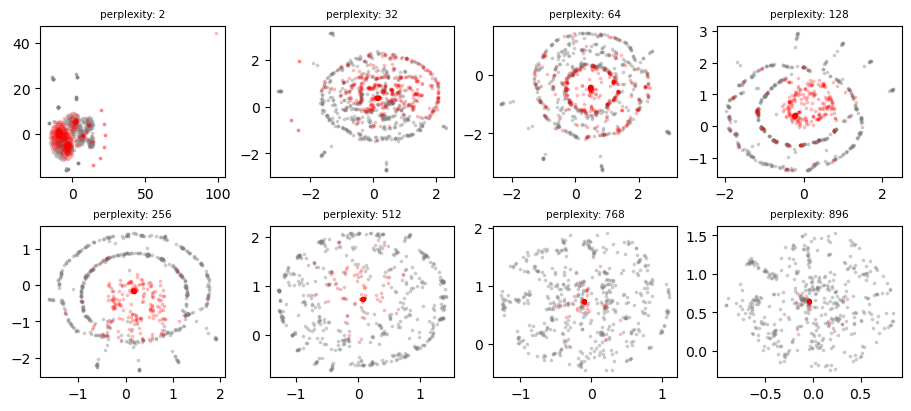

In [18]:
plt.close("all")

fig, axes = plt.subplots(2, 4, figsize=(9, 4), layout="constrained")

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.scatter(tsne_embeddings[i][~y, 0], tsne_embeddings[i][~y, 1], 
               c="gray", label="song", alpha=0.3, s=3)
    ax.scatter(tsne_embeddings[i][y, 0], tsne_embeddings[i][y, 1], 
               c="red", label="ad", alpha=0.2, s=3)

    ax.set_title(f'perplexity: {params_combined[i]["perplexity"]}', fontsize=7.5)


# plt.legend(loc="upper right")

plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-tsne.png", dpi=300)

plt.show()

### UMAP

* euclidean
* manhattan
* chebyshev
* minkowski
* canberra
* braycurtis
* mahalanobis
* wminkowski
* seuclidean
* cosine
* correlation
* haversine
* hamming
* jaccard
* dice
* russelrao
* kulsinski
* ll_dirichlet
* hellinger
* rogerstanimoto
* sokalmichener
* sokalsneath
* yule

In [56]:
nn_range = [2, 5, 15, 50, 100, 150, 200, 500]
metric_range = ["chebychev"]

In [57]:
param_grid_umap = {
    'n_components': [2],
    'min_dist': [0.0],
    'n_neighbors': nn_range,
    'metric': metric_range 
}
grid_umap = list(ParameterGrid(param_grid_umap))

In [168]:
params_combined = grid_umap

In [169]:
umap_embeddings = []
for params in grid_umap:
    model = umap.UMAP(**params)
    embedding = model.fit_transform(X)
    umap_embeddings.append(embedding)

/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


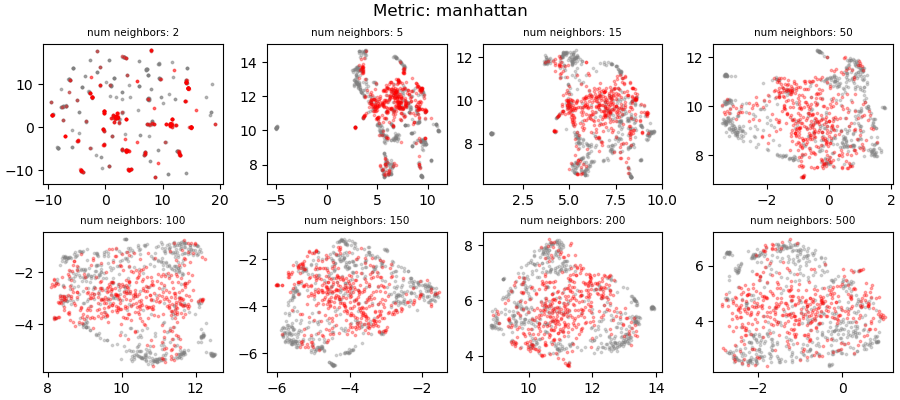

In [170]:
plt.close("all")

fig, axes = plt.subplots(2, 4, figsize=(9, 4), layout="constrained")

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.scatter(umap_embeddings[i][~y, 0], umap_embeddings[i][~y, 1], 
               c="gray", label="song", alpha=0.3, s=3)
    ax.scatter(umap_embeddings[i][y, 0], umap_embeddings[i][y, 1], 
               c="red", label="ad", alpha=0.3, s=3)

    ax.set_title(f'num neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)

# plt.legend(loc="upper right")

fig.suptitle(f'Metric: {params_combined[i]["metric"]}')

plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-umap-{params_combined[i]['metric']}.png", dpi=300)

plt.show()

### UMAP – all

In [11]:
nn_range = [2, 5, 15, 50, 100, 150, 200, 500]

In [15]:
distance_metrics = [
    # "euclidean",
    # "manhattan",
    # "chebyshev",
    # "minkowski",
    # "canberra",
    # "braycurtis",
    # "cosine",
    # "correlation",
]

In [ ]:
for metric_range in tqdm(distance_metrics):
    param_grid_umap = {
        'n_components': [2],
        'min_dist': [0.0],
        'n_neighbors': nn_range,
        'metric': [metric_range] 
    }
    grid_umap = list(ParameterGrid(param_grid_umap))

    params_combined = grid_umap

    # project datapoints to embedding
    umap_embeddings = []
    for params in grid_umap:
        model = umap.UMAP(**params)
        embedding = model.fit_transform(X)
        umap_embeddings.append(embedding)


    # plot
    plt.close("all")
    
    fig, axes = plt.subplots(2, 4, figsize=(9, 4), layout="constrained")
    
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        ax.scatter(umap_embeddings[i][~y, 0], umap_embeddings[i][~y, 1], 
                   c="gray", label="song", alpha=0.3, s=3)
        ax.scatter(umap_embeddings[i][y, 0], umap_embeddings[i][y, 1], 
                   c="red", label="ad", alpha=0.3, s=3)
    
        ax.set_title(f'num neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)
    
    # plt.legend(loc="upper right")
    
    fig.suptitle(f'Metric: {params_combined[i]["metric"]}')
    
    plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-umap-{params_combined[i]['metric']}.png", dpi=300)
    
    plt.close("all")

Supervised clustering with UMAP

In [18]:
distance_metrics = [
    "euclidean",
    "manhattan",
    "chebyshev",
    "minkowski",
    "canberra",
    "braycurtis",
    "cosine",
    "correlation",
]

In [19]:
target = [1 if x else 0 for x in y]

In [20]:
for metric_range in tqdm(distance_metrics):
    param_grid_umap = {
        'n_components': [2],
        'min_dist': [0.0],
        'n_neighbors': nn_range,
        'metric': [metric_range] 
    }
    grid_umap = list(ParameterGrid(param_grid_umap))

    params_combined = grid_umap

    # project datapoints to embedding
    umap_embeddings = []
    for params in grid_umap:
        model = umap.UMAP(**params)
        embedding = model.fit_transform(X, y=target)
        umap_embeddings.append(embedding)


    # plot
    plt.close("all")
    
    fig, axes = plt.subplots(2, 4, figsize=(9, 4), layout="constrained")
    
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        ax.scatter(umap_embeddings[i][~y, 0], umap_embeddings[i][~y, 1], 
                   c="gray", label="song", alpha=0.3, s=3)
        ax.scatter(umap_embeddings[i][y, 0], umap_embeddings[i][y, 1], 
                   c="red", label="ad", alpha=0.3, s=3)
    
        ax.set_title(f'num neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)
    
    # plt.legend(loc="upper right")
    
    fig.suptitle(f'Metric: {params_combined[i]["metric"]}')
    
    plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-supervised-umap-{params_combined[i]['metric']}.png", dpi=300)
    
    plt.close("all")

  0%|                                                     | 0/8 [00:00<?, ?it/s]/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 12%|█████▌                                      | 1/8 [05:14<36:39, 314.14s/it]/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 38%|███████████████▊                          | 3/8 [38:11<1:09:51, 838.40s/it]/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 50%|████████████████████▌                    | 4/8 [59:05<1:06:48, 1002.17s/it]/opt/miniconda3/envs/audio-env/lib/python3.9/site-pac

### Supervised UMAP

Shows most promise from a practical point of view. Let's see how it performs on un-seen data.

In [155]:
kf = KFold(n_splits=5, shuffle=True)

In [156]:
target = np.array([1 if x else 0 for x in y])

In [209]:
nn_range = {
    "euclidean" : [30, 60, 90, 120, 250], # changed
    "manhattan" : [30, 60, 90, 120, 250], # changed
    "chebyshev" : [30, 60, 90, 120, 250], # changed
    "minkowski" : [30, 60, 90, 120, 250], # changed
    "canberra" : [10, 15, 30, 50, 75], # changed
    "braycurtis" : [10, 15, 30, 50, 75], # changed
    "cosine" : [10, 15, 30, 50, 75], # changed
    "correlation" : [10, 15, 30, 50, 75] # changed
}

In [210]:
distance_metrics = [
    "braycurtis",
    "cosine",
    "correlation",
    "euclidean",
    "manhattan",
    "chebyshev",
    "minkowski",
    "canberra"
]

In [211]:
statistics = []

for epoch, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], target[train_idx], target[test_idx]

    fold_statistics = []
    for metric_range in tqdm(distance_metrics):
        print(metric_range)
        # Define parameters
        param_grid_umap = {
            'n_components': [2],
            'min_dist': [0.0],
            'n_neighbors': nn_range[metric_range],
            'metric': [metric_range] 
        }
        grid_umap = list(ParameterGrid(param_grid_umap))
        
        params_combined = grid_umap

        # Perform Grid Search
        umap_train = []
        umap_test = []
        print("performing grid search...")
        for params in tqdm(grid_umap):
        
            model = umap.UMAP(**params, target_weight=0.2).fit(X_train, y=y_train)
            train_embedding = model.embedding_
            test_embedding = model.transform(X_test)
            
            umap_train.append(train_embedding)
            umap_test.append(test_embedding)


        kmeans_labels = []
        for i in range(len(grid_umap)):
            # Perform K Means clustering as a quantification tool
            combined_data = np.concatenate([umap_train[i], umap_test[i]], axis=0)
            
            kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(combined_data)
            
            
            y_pred = kmeans.labels_[X_train.shape[0]:]
            y_true = y_test.astype(np.int32)
            
            corr_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
            
            # If the correlation coefficient is negative, flip the predicted labels
            if corr_coefficient < 0:
                y_pred = 1 - y_pred
                kmeans_labels.append(1 - kmeans.labels_)
            else:
                kmeans_labels.append(kmeans.labels_)
            
            acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            prec = precision_score(y_true, y_pred)
            auroc = roc_auc_score(y_true, y_pred)
            
            fold_statistics.append([acc, f1, prec, auroc])



        # plot
        y_train = y_train.astype(bool)
        y_test = y_test.astype(bool)
            
        plt.close("all")
        
        fig, ax = plt.subplots(len(grid_umap), 2, figsize=(4, 2 * len(grid_umap)))

        for i in range(ax.shape[0]):
        
            ax[i, 0].scatter(umap_train[i][~y_train, 0], umap_train[i][~y_train, 1], 
                       c="gray", label="song-train", alpha=0.3, s=3)
            ax[i, 0].scatter(umap_test[i][~y_test, 0], umap_test[i][~y_test, 1], 
                       c="navy", label="song-test", alpha=0.3, s=3)
            
            ax[i, 0].scatter(umap_train[i][y_train, 0], umap_train[i][y_train, 1], 
                       c="red", label="ad-train", alpha=0.3, s=3)
            ax[i, 0].scatter(umap_test[i][y_test, 0], umap_test[i][y_test, 1], 
                       c="orange", label="ad-test", alpha=0.3, s=3)
            
            ax[i, 0].set_title(f'num neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)

            ax[i, 0].set_xticks([])
            ax[i, 0].set_yticks([])
            
            
            
            # K Means labelling
            combined_data = np.concatenate([umap_train[i], umap_test[i]], axis=0)
            combined_pred = kmeans_labels[i].astype(bool)
            ax[i, 1].scatter(combined_data[~combined_pred, 0], combined_data[~combined_pred, 1], 
                       c="blue", label="song", alpha=0.3, s=3)
            ax[i, 1].scatter(combined_data[combined_pred, 0], combined_data[combined_pred, 1], 
                       c="red", label="ad", alpha=0.3, s=3)
            
            ax[i, 1].set_title('K Means', fontsize=7.5)

            ax[i, 1].set_xticks([])
            ax[i, 1].set_yticks([])
            
            
        fig.suptitle(f'Metric: {metric_range}')
        
        plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-cv{epoch}-umap-{metric_range}.png", dpi=300)
        
        plt.close("all")


    statistics.append(fold_statistics)

  0%|                                                     | 0/8 [00:00<?, ?it/s]

braycurtis
performing grid search...



 12%|█████▎                                    | 1/8 [09:48<1:08:37, 588.15s/it]

cosine
performing grid search...



 25%|██████████▌                               | 2/8 [20:41<1:02:39, 626.67s/it]

correlation
performing grid search...



 38%|███████████████▊                          | 3/8 [41:21<1:15:33, 906.78s/it]

euclidean
performing grid search...



100%|█████████████████████████████████████████████| 5/5 [03:39<00:00, 43.87s/it]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behav

manhattan
performing grid search...



100%|████████████████████████████████████████████| 5/5 [10:38<00:00, 127.76s/it]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:289

chebyshev
performing grid search...



100%|████████████████████████████████████████████| 5/5 [10:38<00:00, 127.69s/it]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:289

minkowski
performing grid search...



100%|████████████████████████████████████████████| 5/5 [13:02<00:00, 156.45s/it]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:289

canberra
performing grid search...



  0%|                                                     | 0/8 [00:00<?, ?it/s]

braycurtis
performing grid search...



 12%|█████▎                                    | 1/8 [10:17<1:11:59, 617.10s/it]

cosine
performing grid search...



 25%|██████████▌                               | 2/8 [21:37<1:05:24, 654.08s/it]

correlation
performing grid search...



 38%|███████████████▊                          | 3/8 [42:44<1:17:51, 934.31s/it]

euclidean
performing grid search...



100%|█████████████████████████████████████████████| 5/5 [03:24<00:00, 40.81s/it]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behav

manhattan
performing grid search...



100%|████████████████████████████████████████████| 5/5 [10:05<00:00, 121.16s/it]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behav

chebyshev
performing grid search...



100%|████████████████████████████████████████████| 5/5 [10:05<00:00, 121.16s/it]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:289

minkowski
performing grid search...



100%|████████████████████████████████████████████| 5/5 [13:02<00:00, 156.58s/it]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:289

canberra
performing grid search...



  0%|                                                     | 0/8 [00:00<?, ?it/s]

braycurtis
performing grid search...



 12%|█████▎                                    | 1/8 [10:16<1:11:58, 616.90s/it]

cosine
performing grid search...



 25%|██████████▌                               | 2/8 [21:37<1:05:24, 654.09s/it]

correlation
performing grid search...



 38%|███████████████▊                          | 3/8 [42:46<1:17:54, 934.93s/it]

euclidean
performing grid search...



100%|█████████████████████████████████████████████| 5/5 [03:25<00:00, 41.03s/it]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 50%|██████████████████████                      | 4/8 [46:11<43:08, 647.06s/it]

manhattan
performing grid search...



100%|████████████████████████████████████████████| 5/5 [10:08<00:00, 121.74s/it]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:289

chebyshev
performing grid search...



100%|████████████████████████████████████████████| 5/5 [10:06<00:00, 121.37s/it]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:289

minkowski
performing grid search...



100%|████████████████████████████████████████████| 5/5 [13:05<00:00, 157.01s/it]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 88%|████████████████████████████████████▊     | 7/8 [1:19:35<11:17, 677.62s/it]

canberra
performing grid search...



  0%|                                                     | 0/8 [00:00<?, ?it/s]

braycurtis
performing grid search...



 12%|█████▎                                    | 1/8 [10:22<1:12:34, 622.04s/it]

cosine
performing grid search...



 25%|██████████▌                               | 2/8 [21:47<1:05:56, 659.42s/it]

correlation
performing grid search...



 38%|███████████████▊                          | 3/8 [43:02<1:18:22, 940.59s/it]

euclidean
performing grid search...



 50%|██████████████████████                      | 4/8 [46:27<43:20, 650.13s/it]

manhattan
performing grid search...



100%|████████████████████████████████████████████| 5/5 [10:05<00:00, 121.09s/it]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:289

chebyshev
performing grid search...



100%|████████████████████████████████████████████| 5/5 [10:05<00:00, 121.07s/it]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 75%|███████████████████████████████▌          | 6/8 [1:06:40<20:49, 624.89s/it]

minkowski
performing grid search...



 88%|████████████████████████████████████▊     | 7/8 [1:19:45<11:16, 676.98s/it]

canberra
performing grid search...



  0%|                                                     | 0/8 [00:00<?, ?it/s]

braycurtis
performing grid search...



 12%|█████▎                                    | 1/8 [10:17<1:11:59, 617.04s/it]

cosine
performing grid search...



 25%|██████████▌                               | 2/8 [21:37<1:05:26, 654.35s/it]

correlation
performing grid search...



 38%|███████████████▊                          | 3/8 [42:46<1:17:55, 935.07s/it]

euclidean
performing grid search...



100%|█████████████████████████████████████████████| 5/5 [03:23<00:00, 40.71s/it]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 50%|██████████████████████                      | 4/8 [46:10<43:06, 646.52s/it]

manhattan
performing grid search...



 62%|███████████████████████████▌                | 5/8 [56:17<31:36, 632.33s/it]

chebyshev
performing grid search...



 75%|███████████████████████████████▌          | 6/8 [1:06:25<20:47, 623.98s/it]

minkowski
performing grid search...



100%|████████████████████████████████████████████| 5/5 [13:03<00:00, 156.65s/it]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 88%|████████████████████████████████████▊     | 7/8 [1:19:29<11:16, 676.25s/it]

canberra
performing grid search...



100%|██████████████████████████████████████████| 8/8 [1:31:55<00:00, 689.47s/it]


In [216]:
statistics = np.array(statistics)

In [218]:
statistics.shape

(5, 40, 4)

In [224]:
avg_statistics = np.mean(statistics, axis=0)

In [255]:
all_parameters = []
for metric_range in distance_metrics:

    param_grid_umap = {
        'n_components': [2],
        'min_dist': [0.0],
        'n_neighbors': nn_range[metric_range],
        'metric': [metric_range] 
    }
    grid_umap = list(ParameterGrid(param_grid_umap))
    
    params_combined = grid_umap

    for params in grid_umap:
        all_parameters.append(params) # in correct order

In [257]:
%matplotlib widget

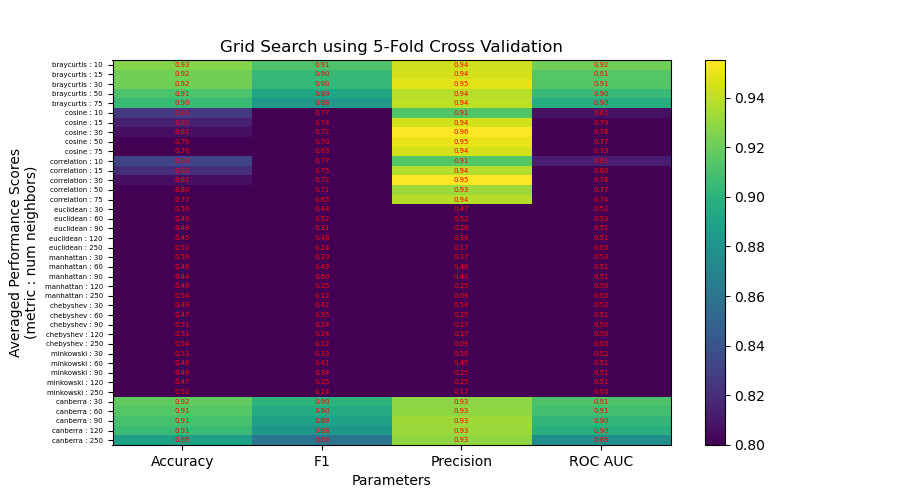

In [267]:
plt.close()

fig = plt.figure(figsize=(9, 5))

im = plt.imshow(avg_statistics, aspect="auto", vmin=0.8)

plt.xlabel("Parameters")
plt.ylabel("Averaged Performance Scores\n(metric : num neighbors)")

plt.colorbar(im)

# Relabeling x-axis ticks
plt.xticks(ticks=np.arange(4), labels=["Accuracy", "F1", "Precision", "ROC AUC"])

# Relabeling y-axis ticks
plt.yticks(ticks=np.arange(len(all_parameters)), labels=[f'{x["metric"]} : {x["n_neighbors"]}' for x in all_parameters], fontsize=5)


# Add text of the value itself in each heatmap pixel
for i in range(len(all_parameters)):
    for j in range(4):
        plt.text(j, i, f'{avg_statistics[i, j]:.2f}', ha='center', va='center', color='red', fontsize=5)

plt.title("Grid Search using 5-Fold Cross Validation")

plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-cv-umap-all-results.png", dpi=400)

plt.show()

Maximimizing F1 Score

In [274]:
f1_idx = 1
k = 0 # max
all_parameters[np.argsort(avg_statistics[:, f1_idx])[::-1][k]]
# Optimal parameter combination

{'metric': 'braycurtis', 'min_dist': 0.0, 'n_components': 2, 'n_neighbors': 10}

In [280]:
for k in range(10):
    top_k_param = all_parameters[np.argsort(avg_statistics[:, f1_idx])[::-1][k]]
    print(f'{top_k_param["metric"]} : {top_k_param["n_neighbors"]} f1={np.sort(avg_statistics[:, f1_idx])[::-1][k] :.3f}')

braycurtis : 10 f1=0.912
braycurtis : 15 f1=0.904
braycurtis : 30 f1=0.903
canberra : 30 f1=0.900
canberra : 60 f1=0.896
braycurtis : 50 f1=0.892
canberra : 90 f1=0.889
braycurtis : 75 f1=0.883
canberra : 120 f1=0.883
canberra : 250 f1=0.859


## Final Eval

UMAP Canberra vs Braycurtis

In [282]:
nn_range = {
    "canberra" : [8, 10, 12, 15, 30, 40, 50], # changed
    "braycurtis" : [8, 10, 12, 15, 30, 40, 50], # changed
}

In [283]:
distance_metrics = [
    "braycurtis",
    "canberra"
]

In [284]:
statistics = []

for epoch, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], target[train_idx], target[test_idx]

    fold_statistics = []
    for metric_range in tqdm(distance_metrics):
        print(metric_range)
        # Define parameters
        param_grid_umap = {
            'n_components': [2],
            'min_dist': [0.0],
            'n_neighbors': nn_range[metric_range],
            'metric': [metric_range] 
        }
        grid_umap = list(ParameterGrid(param_grid_umap))
        
        params_combined = grid_umap

        # Perform Grid Search
        umap_train = []
        umap_test = []
        print("performing grid search...")
        for params in tqdm(grid_umap):
        
            model = umap.UMAP(**params, target_weight=0.2).fit(X_train, y=y_train)
            train_embedding = model.embedding_
            test_embedding = model.transform(X_test)
            
            umap_train.append(train_embedding)
            umap_test.append(test_embedding)


        kmeans_labels = []
        for i in range(len(grid_umap)):
            # Perform K Means clustering as a quantification tool
            combined_data = np.concatenate([umap_train[i], umap_test[i]], axis=0)
            
            kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(combined_data)
            
            
            y_pred = kmeans.labels_[X_train.shape[0]:]
            y_true = y_test.astype(np.int32)
            
            corr_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
            
            # If the correlation coefficient is negative, flip the predicted labels
            if corr_coefficient < 0:
                y_pred = 1 - y_pred
                kmeans_labels.append(1 - kmeans.labels_)
            else:
                kmeans_labels.append(kmeans.labels_)
            
            acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            prec = precision_score(y_true, y_pred)
            auroc = roc_auc_score(y_true, y_pred)
            
            fold_statistics.append([acc, f1, prec, auroc])



        # plot
        y_train = y_train.astype(bool)
        y_test = y_test.astype(bool)
            
        plt.close("all")
        
        fig, ax = plt.subplots(len(grid_umap), 2, figsize=(4, 2 * len(grid_umap)))

        for i in range(ax.shape[0]):
        
            ax[i, 0].scatter(umap_train[i][~y_train, 0], umap_train[i][~y_train, 1], 
                       c="gray", label="song-train", alpha=0.3, s=3)
            ax[i, 0].scatter(umap_test[i][~y_test, 0], umap_test[i][~y_test, 1], 
                       c="navy", label="song-test", alpha=0.3, s=3)
            
            ax[i, 0].scatter(umap_train[i][y_train, 0], umap_train[i][y_train, 1], 
                       c="red", label="ad-train", alpha=0.3, s=3)
            ax[i, 0].scatter(umap_test[i][y_test, 0], umap_test[i][y_test, 1], 
                       c="orange", label="ad-test", alpha=0.3, s=3)
            
            ax[i, 0].set_title(f'num neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)

            ax[i, 0].set_xticks([])
            ax[i, 0].set_yticks([])
            
            
            
            # K Means labelling
            combined_data = np.concatenate([umap_train[i], umap_test[i]], axis=0)
            combined_pred = kmeans_labels[i].astype(bool)
            ax[i, 1].scatter(combined_data[~combined_pred, 0], combined_data[~combined_pred, 1], 
                       c="blue", label="song", alpha=0.3, s=3)
            ax[i, 1].scatter(combined_data[combined_pred, 0], combined_data[combined_pred, 1], 
                       c="red", label="ad", alpha=0.3, s=3)
            
            ax[i, 1].set_title('K Means', fontsize=7.5)

            ax[i, 1].set_xticks([])
            ax[i, 1].set_yticks([])
            
            
        fig.suptitle(f'Metric: {metric_range}')
        
        plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-cv-opt2-{epoch}-umap-{metric_range}.png", dpi=300)
        
        plt.close("all")

    statistics.append(fold_statistics)

  0%|                                                     | 0/2 [00:00<?, ?it/s]

braycurtis
performing grid search...



 50%|██████████████████████                      | 1/2 [13:42<13:42, 822.54s/it]

canberra
performing grid search...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

braycurtis
performing grid search...



 50%|██████████████████████                      | 1/2 [13:56<13:56, 836.78s/it]

canberra
performing grid search...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

braycurtis
performing grid search...



 50%|██████████████████████                      | 1/2 [13:44<13:44, 824.20s/it]

canberra
performing grid search...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

braycurtis
performing grid search...



 50%|██████████████████████                      | 1/2 [13:49<13:49, 829.30s/it]

canberra
performing grid search...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

braycurtis
performing grid search...



 50%|██████████████████████                      | 1/2 [13:52<13:52, 832.86s/it]

canberra
performing grid search...



100%|████████████████████████████████████████████| 2/2 [30:44<00:00, 922.32s/it]


In [285]:
statistics = np.array(statistics)

In [286]:
statistics.shape

(5, 14, 4)

In [287]:
avg_statistics = np.mean(statistics, axis=0)

In [288]:
all_parameters = []
for metric_range in distance_metrics:

    param_grid_umap = {
        'n_components': [2],
        'min_dist': [0.0],
        'n_neighbors': nn_range[metric_range],
        'metric': [metric_range] 
    }
    grid_umap = list(ParameterGrid(param_grid_umap))
    
    params_combined = grid_umap

    for params in grid_umap:
        all_parameters.append(params) # in correct order

In [289]:
%matplotlib widget

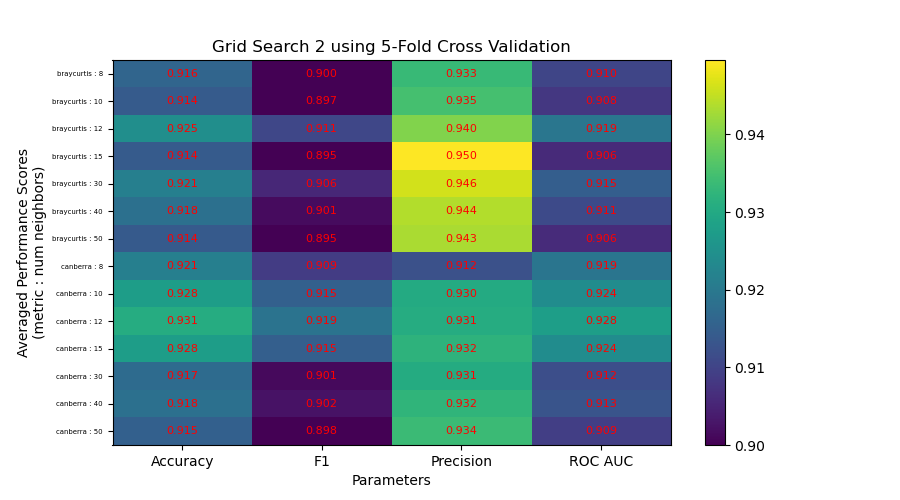

In [294]:
plt.close()

fig = plt.figure(figsize=(9, 5))

im = plt.imshow(avg_statistics, aspect="auto", vmin=0.9)

plt.xlabel("Parameters")
plt.ylabel("Averaged Performance Scores\n(metric : num neighbors)")

plt.colorbar(im)

# Relabeling x-axis ticks
plt.xticks(ticks=np.arange(4), labels=["Accuracy", "F1", "Precision", "ROC AUC"])

# Relabeling y-axis ticks
plt.yticks(ticks=np.arange(len(all_parameters)), labels=[f'{x["metric"]} : {x["n_neighbors"]}' for x in all_parameters], fontsize=5)


# Add text of the value itself in each heatmap pixel
for i in range(len(all_parameters)):
    for j in range(4):
        plt.text(j, i, f'{avg_statistics[i, j]:.3f}', ha='center', va='center', color='red', fontsize=8)

plt.title("Grid Search 2 using 5-Fold Cross Validation")

plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-cv-opt2-umap-all-results.png", dpi=400)

plt.show()

In [293]:
f1_idx = 1
k = 0 # max
all_parameters[np.argsort(avg_statistics[:, f1_idx])[::-1][k]]
# Optimal parameter combination

{'metric': 'canberra', 'min_dist': 0.0, 'n_components': 2, 'n_neighbors': 12}

In [295]:
for k in range(5):
    top_k_param = all_parameters[np.argsort(avg_statistics[:, f1_idx])[::-1][k]]
    print(f'{top_k_param["metric"]} : {top_k_param["n_neighbors"]} f1={np.sort(avg_statistics[:, f1_idx])[::-1][k] :.3f}')

canberra : 12 f1=0.919
canberra : 10 f1=0.915
canberra : 15 f1=0.915
braycurtis : 12 f1=0.911
canberra : 8 f1=0.909


Conclusions 
- From just the plots, we see that Canberra is less prone to overfitting for the same num neighbors
- Canberra has a better mathematical justification (defined over vector spaces) as opposed to the domain specific Braycurtis dissimilarity

Final model: {'metric': 'canberra', 'min_dist': 0.0, 'n_components': 2, 'n_neighbors': 12}


## Appendix

In [26]:
kf = KFold(n_splits=5, shuffle=True)

In [29]:
target = np.array([1 if x else 0 for x in y])

In [86]:
for i, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], target[train_idx], target[test_idx]
    break

In [32]:
nn_range = {
    "euclidean" : [60, 70, 80, 90, 100, 250], # changed
    "manhattan" : [60, 70, 80, 90, 100, 250], # changed
    "chebyshev" : [60, 70, 80, 90, 100, 250], # changed
    "minkowski" : [60, 70, 80, 90, 100, 250], # changed
    "canberra" : [70, 80, 90, 100, 250, 500], # changed
    "braycurtis" : [10, 15, 30, 50, 75, 100], # changed
    "cosine" : [10, 15, 30, 50, 75, 100], # changed
    "correlation" : [10, 15, 30, 50, 75, 100] # changed
}

In [33]:
distance_metrics = [
    "euclidean",
    "manhattan",
    "chebyshev",
    "minkowski",
    "canberra",
    "braycurtis",
    "cosine",
    "correlation",
]

In [39]:
metric_range = "braycurtis" # replace with for loop later on (metric_range is for loop variable)

In [40]:
param_grid_umap = {
    'n_components': [2],
    'min_dist': [0.0],
    'n_neighbors': nn_range[metric_range],
    'metric': [metric_range] 
}
grid_umap = list(ParameterGrid(param_grid_umap))

params_combined = grid_umap

In [46]:
params = grid_umap[2]
params

{'metric': 'braycurtis', 'min_dist': 0.0, 'n_components': 2, 'n_neighbors': 30}

In [87]:
# project datapoints to embedding
umap_train = []
umap_test = []
# for params in grid_umap:

model = umap.UMAP(**params).fit(X_train, y=y_train)
train_embedding = model.embedding_
test_embedding = model.transform(X_test)

umap_train.append(train_embedding)
umap_test.append(test_embedding)

In [88]:
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

In [89]:
umap_test[i][y_test, 0].shape

(94,)

In [90]:
umap_test[i][~y_test, 0].shape

(100,)

In [91]:
umap_train[i][y_train, 0].shape

(323,)

In [92]:
umap_train[i][~y_train, 0].shape

(450,)

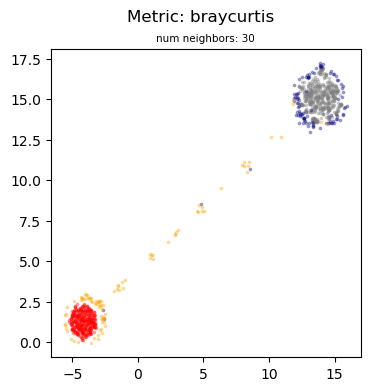

In [107]:
# plot
plt.close("all")

fig, ax = plt.subplots(figsize=(4, 4))

# axes = axes.flatten()

i = 0
ax.scatter(umap_train[i][~y_train, 0], umap_train[i][~y_train, 1], 
           c="gray", label="song-train", alpha=0.3, s=3)
ax.scatter(umap_test[i][~y_test, 0], umap_test[i][~y_test, 1], 
           c="navy", label="song-test", alpha=0.3, s=3)

ax.scatter(umap_train[i][y_train, 0], umap_train[i][y_train, 1], 
           c="red", label="ad-train", alpha=0.3, s=3)
ax.scatter(umap_test[i][y_test, 0], umap_test[i][y_test, 1], 
           c="orange", label="ad-test", alpha=0.3, s=3)

# ax.set_title(f'num neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)
ax.set_title(f'num neighbors: {params["n_neighbors"]}', fontsize=7.5)

# plt.legend(loc="upper right")

# fig.suptitle(f'Metric: {params_combined[i]["metric"]}')
fig.suptitle(f'Metric: {params["metric"]}')

# plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-supervised-umap-{params_combined[i]['metric']}.png", dpi=300)

plt.show()

In [115]:
combined = np.concatenate([umap_train[i], umap_test[i]], axis=0)

In [116]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(combined)

In [142]:
y_true = y_test.astype(np.int32)
y_pred = 1 - kmeans.labels_[X_train.shape[0]:]

In [144]:
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"F1 Score: {f1_score(y_true, y_pred)}")
print(f"Precision Score: {precision_score(y_true, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_true, y_pred)}")

Accuracy: 0.9175257731958762
F1 Score: 0.9101123595505618
Precision Score: 0.9642857142857143
ROC AUC Score: 0.9158510638297872


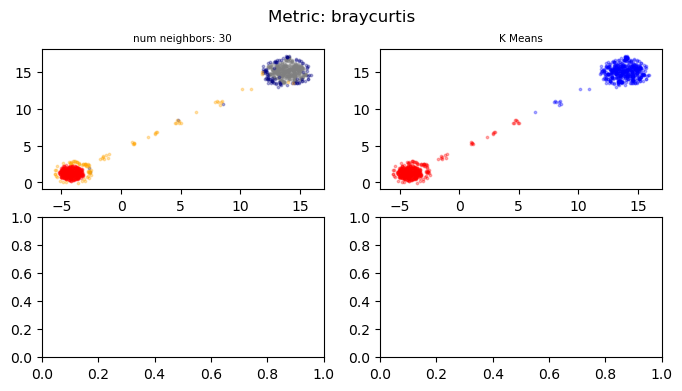

In [154]:
# plot
plt.close("all")

fig, ax = plt.subplots(2, 2, figsize=(8, 4))

i = 0

ax[i, 0].scatter(umap_train[i][~y_train, 0], umap_train[i][~y_train, 1], 
           c="gray", label="song-train", alpha=0.3, s=3)
ax[i, 0].scatter(umap_test[i][~y_test, 0], umap_test[i][~y_test, 1], 
           c="navy", label="song-test", alpha=0.3, s=3)

ax[i, 0].scatter(umap_train[i][y_train, 0], umap_train[i][y_train, 1], 
           c="red", label="ad-train", alpha=0.3, s=3)
ax[i, 0].scatter(umap_test[i][y_test, 0], umap_test[i][y_test, 1], 
           c="orange", label="ad-test", alpha=0.3, s=3)

# ax.set_title(f'num neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)
ax[i, 0].set_title(f'num neighbors: {params["n_neighbors"]}', fontsize=7.5)



# K Means labelling
combined_pred = kmeans.labels_.astype(bool)
ax[i, 1].scatter(combined_data[~combined_pred, 0], combined_data[~combined_pred, 1], 
           c="red", label="song", alpha=0.3, s=3)
ax[i, 1].scatter(combined_data[combined_pred, 0], combined_data[combined_pred, 1], 
           c="blue", label="ad", alpha=0.3, s=3)

# ax.set_title('K Means', fontsize=7.5)
ax[i, 1].set_title('K Means', fontsize=7.5)


# fig.suptitle(f'Metric: {params_combined[i]["metric"]}')
fig.suptitle(f'Metric: {params["metric"]}')

# plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-supervised-umap-{params_combined[i]['metric']}.png", dpi=300)

plt.show()

## Plots

In [60]:
embedding_dim = 3

In [66]:
pca = PCA(n_components=embedding_dim)
model_pca = pca.fit(X)
embed_pca = model_pca.transform(X)
fit_variances = model_pca.explained_variance_ratio_

spectral = SpectralEmbedding(**{'affinity': 'nearest_neighbors', 'n_components': embedding_dim, 'n_neighbors': 16})
embed_spectral = spectral.fit_transform(X)

model = TSNE(**{'n_components': embedding_dim, 'perplexity': 256}, n_iter=10000)
embed_tnse = model.fit_transform(X)

model = umap.UMAP(**{'metric': 'chebyshev', 'min_dist': 0.0, 'n_components': embedding_dim, 'n_neighbors': 50})
embed_umap = model.fit_transform(X)

In [68]:
%matplotlib widget

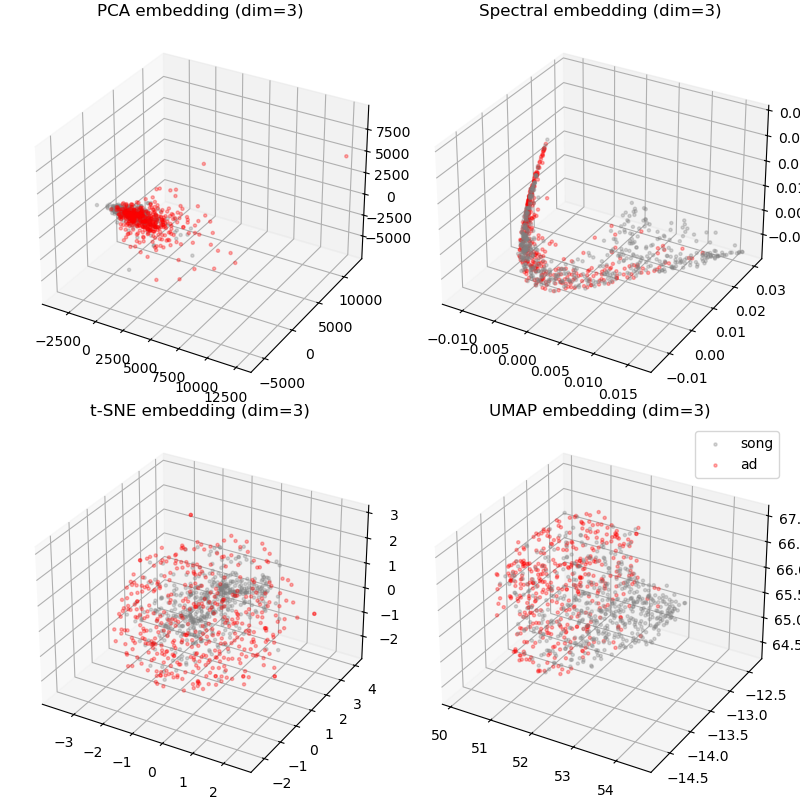

In [69]:
plt.close("all")

fig, ax = plt.subplots(2, 2, figsize=(8, 8), layout="constrained", subplot_kw=dict(projection="3d"))

ax = ax.flatten()

ax[0].scatter3D(embed_pca[~y, 0], embed_pca[~y, 1], embed_pca[~y, 2],
              c="gray", label="song", alpha=0.3, s=5)
ax[0].scatter3D(embed_pca[y, 0], embed_pca[y, 1], embed_pca[y, 2],
              c="red", label="ad", alpha=0.3, s=5)
ax[0].set_title(f"PCA embedding (dim={embedding_dim})")


ax[1].scatter3D(embed_spectral[~y, 0], embed_spectral[~y, 1], embed_spectral[~y, 2],
              c="gray", label="song", alpha=0.3, s=5)
ax[1].scatter3D(embed_spectral[y, 0], embed_spectral[y, 1], embed_spectral[y, 2],
              c="red", label="ad", alpha=0.3, s=5)
ax[1].set_title(f"Spectral embedding (dim={embedding_dim})")


ax[2].scatter3D(embed_tnse[~y, 0], embed_tnse[~y, 1], embed_tnse[~y, 2],
              c="gray", label="song", alpha=0.3, s=5)
ax[2].scatter3D(embed_tnse[y, 0], embed_tnse[y, 1], embed_tnse[y, 2],
              c="red", label="ad", alpha=0.3, s=5)
ax[2].set_title(f"t-SNE embedding (dim={embedding_dim})")


ax[3].scatter3D(embed_umap[~y, 0], embed_umap[~y, 1], embed_umap[~y, 2],
              c="gray", label="song", alpha=0.3, s=5)
ax[3].scatter3D(embed_umap[y, 0], embed_umap[y, 1], embed_umap[y, 2],
              c="red", label="ad", alpha=0.3, s=5)
ax[3].set_title(f"UMAP embedding (dim={embedding_dim})")

plt.legend(loc="best")

# plt.savefig(f"graphics/embedding-{embedding_dim}d.png", dpi=300)

plt.show()